# **Loading Data**

In [2]:
import pandas as pd

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_clean = pd.read_csv("/content/drive/MyDrive/conservative_sept_nov_2024_clean.csv")

In [4]:
df_clean.shape

(219929, 5)

In [5]:
df_clean.columns

Index(['author', 'link_id', 'created_utc', 'body', 'score'], dtype='object')

# **Co-commenting network**

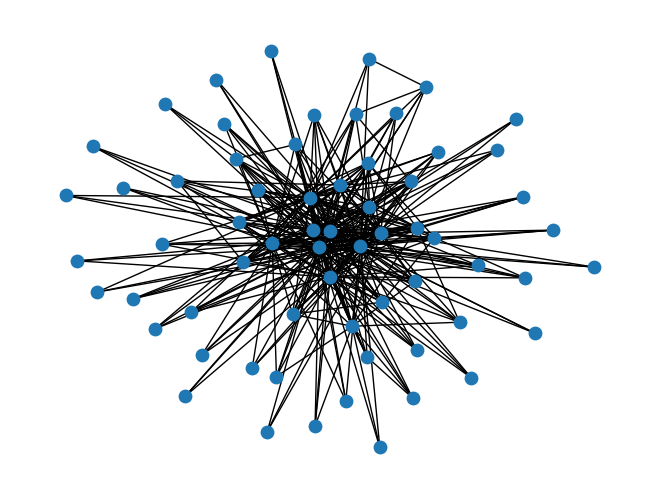

Saved.


In [7]:
import itertools
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt

min_shared = 40 # We keep edges with weight >= 40
min_degree = 3 # We keep nodes with degree >= 3

comments = df_clean.dropna(subset=["author", "link_id"])

post_groups = comments.groupby("link_id")["author"].apply(list)

pair_counts = Counter()
for users in post_groups:
    users = list(set(users)) # deduplicate the users
    if len(users) > 1:
        pair_counts.update(itertools.combinations(sorted(users), 2))

edges = [(u1, u2, {'weight': w}) for (u1, u2), w in pair_counts.items() if w >= min_shared]

G = nx.Graph()
G.add_edges_from(edges)

to_remove = [n for n, deg in G.degree() if deg < min_degree]
G.remove_nodes_from(to_remove)

if G.number_of_edges() < 500 and G.number_of_nodes() > 0:
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=False, node_size=80)
    plt.show()


nx.write_gexf(G, "/content/drive/MyDrive/cocommenting_network.gexf")
print("Saved.")


 ## **Top User pairs**

In [9]:
top_pairs = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
print("Top 15 user pairs by shared posts:")
for u1, u2, data in top_pairs[:15]:
    print(f"{u1} ↔ {u2}: {data['weight']} shared posts")


Top 15 user pairs by shared posts:
JediJones77 ↔ hey_ringworm: 183 shared posts
JediJones77 ↔ D_Ethan_Bones: 168 shared posts
JediJones77 ↔ day25: 161 shared posts
JediJones77 ↔ sowellpatrol: 147 shared posts
JediJones77 ↔ skarface6: 143 shared posts
JediJones77 ↔ FourtyMichaelMichael: 127 shared posts
D_Ethan_Bones ↔ lawlygagger: 121 shared posts
JediJones77 ↔ GeorgeWashingfun: 118 shared posts
JediJones77 ↔ lawlygagger: 113 shared posts
JediJones77 ↔ HuntForRedOctober2: 109 shared posts
JediJones77 ↔ vegatx40: 108 shared posts
skarface6 ↔ hey_ringworm: 102 shared posts
JediJones77 ↔ NinjaAncient4010: 100 shared posts
JediJones77 ↔ AIDS_Quilt_69: 100 shared posts
D_Ethan_Bones ↔ day25: 99 shared posts


## **Degree for top users**

In [11]:
degree_dict = dict(G.degree())
top_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:15]

print("Top users by number of connections:")
for user, deg in top_degree:
    print(f"{user}: {deg} connections")


Top users by number of connections:
JediJones77: 63 connections
D_Ethan_Bones: 51 connections
hey_ringworm: 51 connections
sowellpatrol: 37 connections
skarface6: 36 connections
day25: 33 connections
lawlygagger: 29 connections
FourtyMichaelMichael: 22 connections
Whole-Essay640: 19 connections
GeorgeWashingfun: 18 connections
Crisgocentipede: 16 connections
Imissyourgirlfriend2: 16 connections
social_dinosaur: 14 connections
the_house_from_up: 12 connections
NinjaAncient4010: 11 connections


## **Community detection**

In [12]:
!pip install python-louvain

In [24]:
import community.community_louvain as community_louvain

partition = community_louvain.best_partition(G, weight='weight', random_state=42)
modularity = community_louvain.modularity(partition, G, weight='weight')
print("Modularity:", modularity)

print(f"Louvain detected {len(set(partition.values()))} communities")

Modularity: 0.10579216036578905
Louvain detected 4 communities


In [30]:
from collections import defaultdict

clusters = defaultdict(list)
for user, cid in partition.items():
    clusters[cid].append(user)

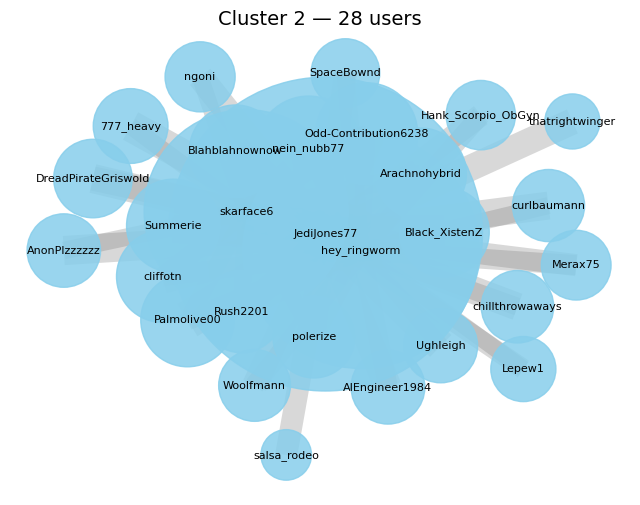

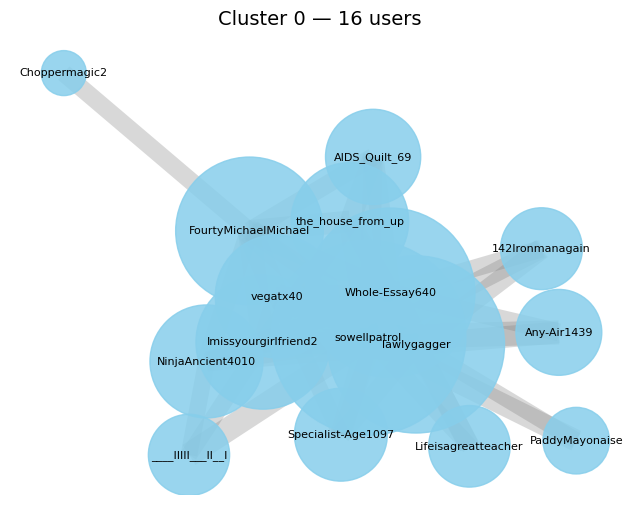

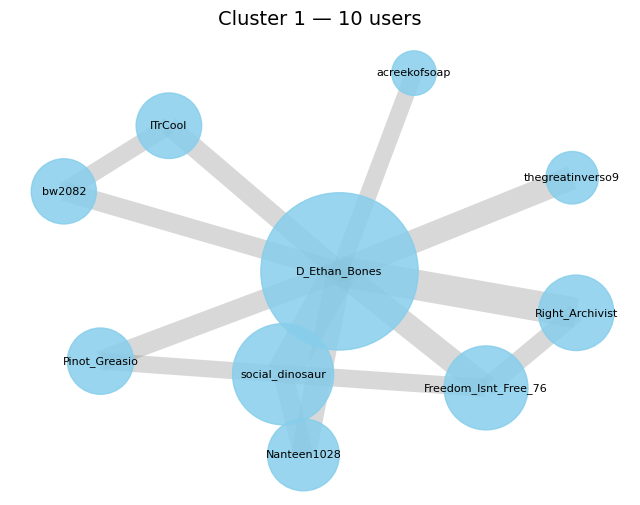

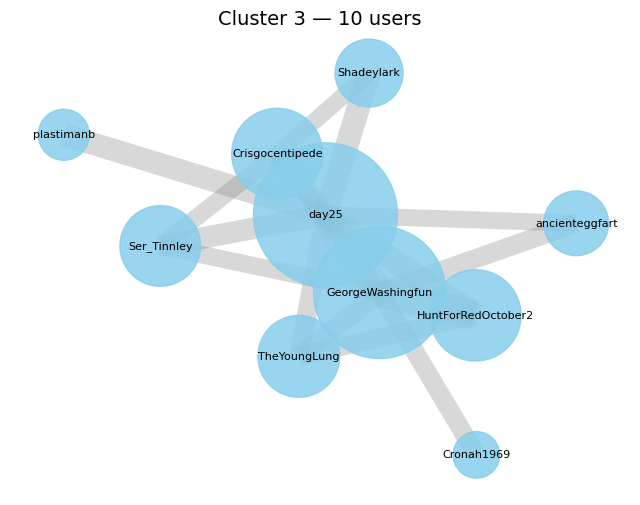

In [31]:
sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)

for i, (cid, users) in enumerate(sorted_clusters[:5]):
    subG = G.subgraph(users)
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(subG, k=0.4, seed=42)

    node_sizes = [
        sum(d['weight'] for _, _, d in subG.edges(n, data=True)) * 25
        for n in subG.nodes()
    ]
    edge_widths = [d['weight'] * 0.3 for _, _, d in subG.edges(data=True)]

    nx.draw_networkx_edges(subG, pos, alpha=0.3, width=edge_widths, edge_color="gray")
    nx.draw_networkx_nodes(subG, pos, node_size=node_sizes, node_color="skyblue", alpha=0.85)
    nx.draw_networkx_labels(subG, pos, font_size=8)
    plt.title(f"Cluster {cid} — {len(subG)} users", fontsize=14)
    plt.axis("off")
    plt.show()


## **Community Metrics**

In [42]:
from collections import defaultdict, Counter


m2 = 2 * sum(d['weight'] for _, _, d in G.edges(data=True))
k = {
    n: sum(d['weight'] for _, _, d in G.edges(n, data=True))
    for n in G.nodes()
}

# Community metrics
def community_stats(nodes):
    S = set(nodes)

    w_in = 0.0
    w_cut = 0.0
    for u in S:
        for v, d in G[u].items():
            w = d['weight']
            if v in S:
                w_in += w
            else:
                w_cut += w
    w_in /= 2.0  # counted twice

    # Sum of degrees
    sum_k = sum(k[n] for n in S)

    # Weighted density
    n = len(S)
    max_pairs = n * (n - 1) / 2
    density_w = (w_in / max_pairs) if max_pairs > 0 else 0.0

    # Conductance
    denom = (2 * w_in + w_cut)
    conduct = (w_cut / denom) if denom > 0 else 0.0

    return {
        "n": n,
        "w_in": w_in,
        "w_cut": w_cut,
        "sum_k": sum_k,
        "density_w": density_w,
        "conductance": conduct
    }

def user_core_scores(nodes):
    S = set(nodes)
    rows = []
    for u in S:
        tot = k[u]
        w_int = sum(d['weight'] for _, v, d in G.edges(u, data=True) if v in S)
        ratio = (w_int / tot) if tot > 0 else 0.0
        rows.append((u, ratio, tot, w_int))
    rows.sort(key=lambda x: (x[1], x[3], x[2]), reverse=True)
    return rows

stats = {cid: community_stats(users) for cid, users in clusters.items()}

for cid, users in clusters.items():
    s = stats[cid]
    print(f"Community {cid}: n={s['n']}, density_w={s['density_w']:.4f}, conductance={s['conductance']:.3f}")
    top_users = user_core_scores(users)[:10]
    print("Top core users (internal_ratio, total_w, internal_w):")
    for u, r, tot, w_int in top_users:
        print(f"{u}, {r}, tot={tot}, in={w_int}")
    print()


Community 2: n=28, density_w=9.7196, conductance=0.516
Top core users (internal_ratio, total_w, internal_w):
Blahblahnownow, 1.0, tot=177, in=177
Rush2201, 1.0, tot=140, in=140
polerize, 0.7679558011049724, tot=181, in=139
Black_XistenZ, 0.751131221719457, tot=221, in=166
AnonPlzzzzzz, 0.7320261437908496, tot=153, in=112
chillthrowaways, 0.7315436241610739, tot=149, in=109
curlbaumann, 0.72, tot=150, in=108
Woolfmann, 0.7181208053691275, tot=149, in=107
Palmolive00, 0.6908396946564885, tot=262, in=181
SpaceBownd, 0.6901408450704225, tot=142, in=98

Community 1: n=10, density_w=16.2444, conductance=0.762
Top core users (internal_ratio, total_w, internal_w):
Nanteen1028, 0.5219512195121951, tot=205, in=107
ITrCool, 0.4494949494949495, tot=198, in=89
Pinot_Greasio, 0.3991228070175439, tot=228, in=91
bw2082, 0.3384615384615385, tot=260, in=88
acreekofsoap, 0.3228346456692913, tot=127, in=41
Freedom_Isnt_Free_76, 0.2874015748031496, tot=508, in=146
social_dinosaur, 0.26108374384236455, tot=

In [43]:
import os
OUT_DIR = "/content/drive/MyDrive/gephi_subgraphs"
os.makedirs(OUT_DIR, exist_ok=True)

for cid, users in clusters.items():
    subG = G.subgraph(users).copy()
    fname = f"cluster_{cid}_n{subG.number_of_nodes()}_e{subG.number_of_edges()}.gexf"
    nx.write_gexf(subG, os.path.join(OUT_DIR, fname))


In [44]:
import shutil
shutil.make_archive("/content/gephi_subgraphs", "zip", "/content/drive/MyDrive/gephi_subgraphs")
from google.colab import files
files.download("/content/gephi_subgraphs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**High Activity Code**

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

user_activity = df_clean["author"].value_counts().reset_index()
user_activity.columns = ["author", "comment_count"]

# Rank-based normalization
user_activity["rank"] = user_activity["comment_count"].rank(method="min", ascending=False)
user_activity["rank_norm"] = 1 - (user_activity["rank"] - 1) / (len(user_activity) - 1)

# List of suspicious users
suspicious_users = [
    "777_heavy", "Arachnohybrid", "ancienteggfart", "BlackTrigger77", "Blahblahnownow",
    "Best-Dragonfruit-292", "ConsciousKiwi9", "Content_Structure118", "curlbaumann",
    "chances906", "deciduousredcoat", "Enchylada", "Entilen", "fredemu", "GimmeeSomeMo",
    "H3nchman_24", "Hank_Scorpio_ObGyn", "Hour_Insurance_7795", "Ineeboopiks", "JediJones77",
    "JerseyKeebs", "lawlygagger", "Odd-Contribution6238", "Palmolive00", "Panzershrekt",
    "Pinot_Greasio", "Ser_Tinnley", "sdevil713", "snestalgia64", "TheYoungLung", "Tough_guy22",
    "WorkingThroughIt7989", "____IIIII___ll__I", "142Ironmanagain", "AIDS_Quilt_69",
    "AIEngineer1984", "AnonPlzzzzzz", "Any-Air1439", "acreekofsoap", "Black_XistenZ", "bw2082",
    "Choppermagic2", "chillthrowaways", "cliffotn", "Crisgocentipede", "Cronah1969",
    "D_Ethan_Bones", "day25", "DreadPirateGriswold", "FourtyMichaelMichael",
    "Freedom_Isnt_Free_76", "GeorgeWashingfun", "hey_ringworm", "HuntForRedOctober2", "ITrCool",
    "Imissyourgirlfriend2", "Lepew1", "Lifeisagreatteacher", "Merax75", "Nanteen1028",
    "nein_nubb77", "ngoni", "NinjaAncient4010", "PaddyMayonaise", "plastimanb", "polerize",
    "Right_Archivist", "Rush2201", "salsa_rodeo", "Shadeylark", "skarface6", "social_dinosaur",
    "sowellpatrol", "SpaceBownd", "Specialist-Age1097", "Summerie", "thatrightwinger",
    "the_house_from_up", "thegreatinverso9", "Ughleigh", "vegatx40", "Whole-Essay640", "Woolfmann"
]

suspicious_df = pd.DataFrame(suspicious_users, columns=["author"])
merged = suspicious_df.merge(user_activity, on="author", how="left")
merged["comment_count"] = merged["comment_count"].fillna(0).astype(int)
merged["rank_norm"] = merged["rank_norm"].fillna(0)
merged = merged.sort_values(by="rank_norm", ascending=False).reset_index(drop=True)
merged.to_csv("/content/suspicious_user_rank_normalized.csv", index=False)
print(merged.head())


            author  comment_count  rank  rank_norm
0      JediJones77           3438   1.0   1.000000
1    D_Ethan_Bones           1249   2.0   0.999957
2  social_dinosaur            949   3.0   0.999914
3     sowellpatrol            930   4.0   0.999871
4    Arachnohybrid            871   5.0   0.999828


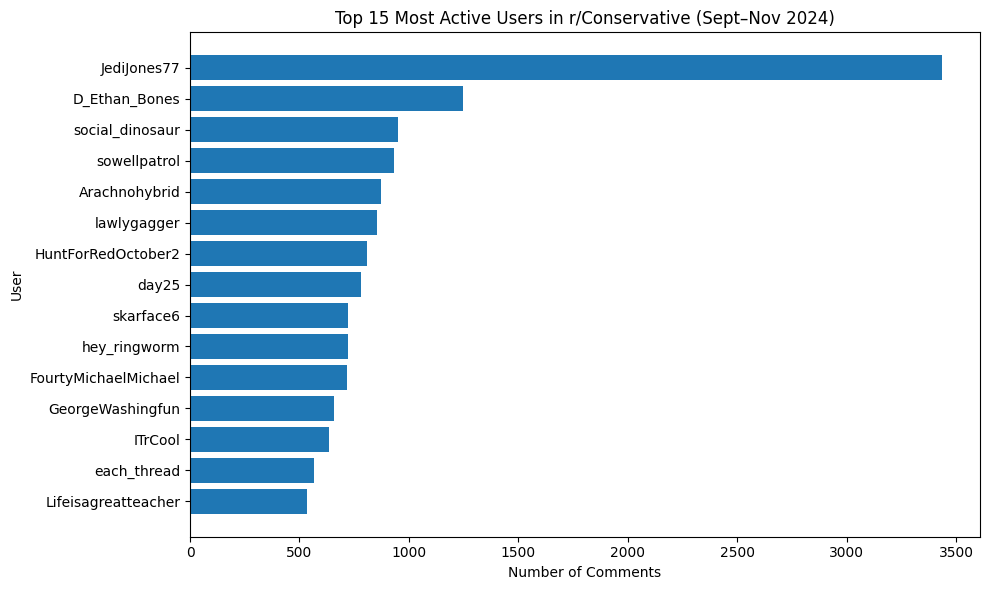

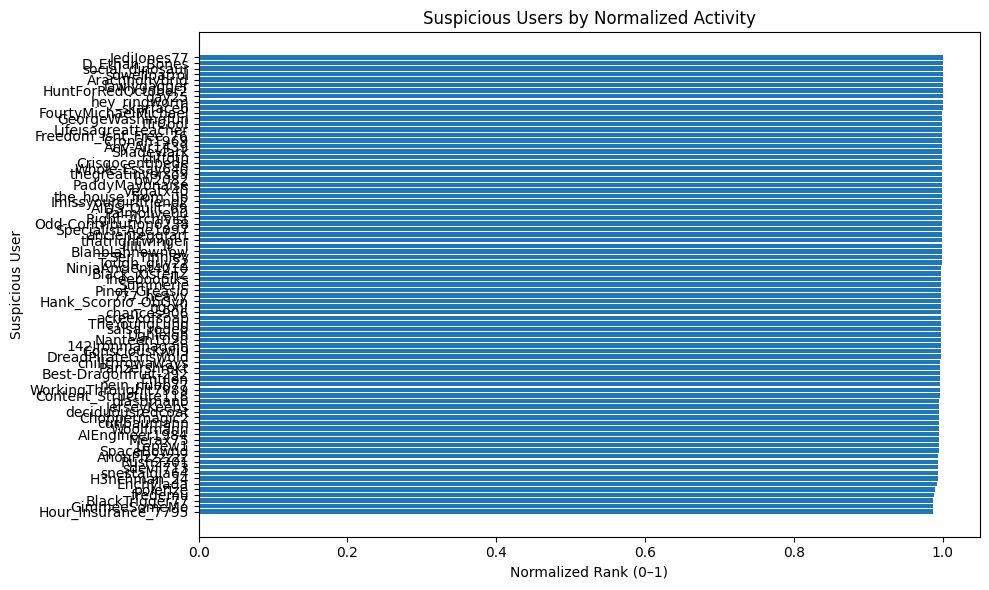

In [46]:
#Plotting top 15 users

top_n = 15
top_users = user_activity.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_users["author"][::-1], top_users["comment_count"][::-1])
plt.xlabel("Number of Comments")
plt.ylabel("User")
plt.title(f"Top {top_n} Most Active Users in r/Conservative (Sept–Nov 2024)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(merged["author"][::-1], merged["rank_norm"][::-1])
plt.xlabel("Normalized Rank (0–1)")
plt.ylabel("Suspicious User")
plt.title("Suspicious Users by Normalized Activity")
plt.tight_layout()
plt.show()

In [29]:
# Printing unique users
n_users= df_clean["author"].nunique(dropna=True)

print(f"Unique users: {n_users}")

Unique users: 23296
